# Plot trans percentage

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from scipy.stats import mannwhitneyu
import itertools

In [2]:
pd.options.mode.copy_on_write = True

In [3]:
# figure save directory
figure_dir = Path(
    "/tscc/projects/ps-epigen/users/biy022/scmethylhic/human_hippocampus/snm3c/Combined/hic/figures/")

In [4]:
# Load meta file
meta_file = "/tscc/projects/ps-renlab2/sel041/scmethylhic/human_hippocampus/concat/human_aging_final_metadata.csv.gz"
meta_df = pd.read_csv(meta_file, header=0, index_col=1)
meta_df.drop(meta_df.columns[0], axis=1, inplace=True)

In [5]:
meta_df = meta_df[[
    "TransContact", "CisLongContact", "CisShortContact", "TotalContacts", 
    "donor", "final_cluster", "group"
]]
meta_df.loc[meta_df["final_cluster"].isin(["Micro1", "Micro2"]), "final_cluster"] = "Microglia"
meta_df.loc[meta_df["final_cluster"].isin(["Astro1", "Astro2"]), "final_cluster"] = "Astro"

In [6]:
subclass_order = [
    "Astro", "Oligo", "OPC", "Microglia", "Endo", "VLMC",
    "SUB", "CA", "DG",
    "PVALB", "SST", "NR2F2-LAMP5", "VIP"
]

In [7]:
meta_df.final_cluster = pd.Categorical(
    meta_df.final_cluster, categories=subclass_order)
meta_df.group = pd.Categorical(
    meta_df.group, categories=["20-40", "40-60", "60-80", "80-100"])

In [8]:
meta_df["TransRatio"] = meta_df["TransContact"] / \
    (meta_df["TransContact"] + meta_df["CisLongContact"])

In [9]:
n_celltypes = meta_df["final_cluster"].unique().size
n_groups = 4
test_results = pd.DataFrame({
    "celltype": itertools.chain.from_iterable([x] * n_groups for x in subclass_order),
    "group": ["20-40", "40-60", "60-80", "80-100"] * n_celltypes,
    "pvalue": [0.0] * (n_celltypes * n_groups),
    "stars": [""] * (n_celltypes * n_groups),
})

In [10]:
test_results["celltype"] = pd.Categorical(
    test_results["celltype"], categories=subclass_order, ordered=True)
test_results["group"] = pd.Categorical(
    test_results["group"], categories=["20-40", "40-60", "60-80", "80-100"], ordered=True)

In [11]:
for celltype, subdf in meta_df.groupby("final_cluster"):
    x = subdf.loc[subdf["group"] == "20-40", "TransRatio"]
    for group in ["40-60", "60-80", "80-100"]:
        y = subdf.loc[subdf["group"] == group, "TransRatio"]
        stat, p_value = mannwhitneyu(x, y)

        sel_index = (test_results["celltype"] == celltype) & (test_results["group"] == group)
        test_results.loc[sel_index, "pvalue"] = p_value

        stars = ""
        if p_value < 0.01:
            stars = "*"
        if p_value < 0.001:
            stars = "**"
        test_results.loc[sel_index, "stars"] = stars

/tmp/ipykernel_1215964/2967400353.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for celltype, subdf in meta_df.groupby("final_cluster"):


In [12]:
import seaborn as sns

In [13]:
age_colors = {
    "20-40": "#1B9E77",
    "40-60": "#CCCD66",
    "60-80": "#7570B3",
    "80-100": "#E7298A"
}

In [14]:
test_results = test_results.sort_values(by=["group", "celltype"])

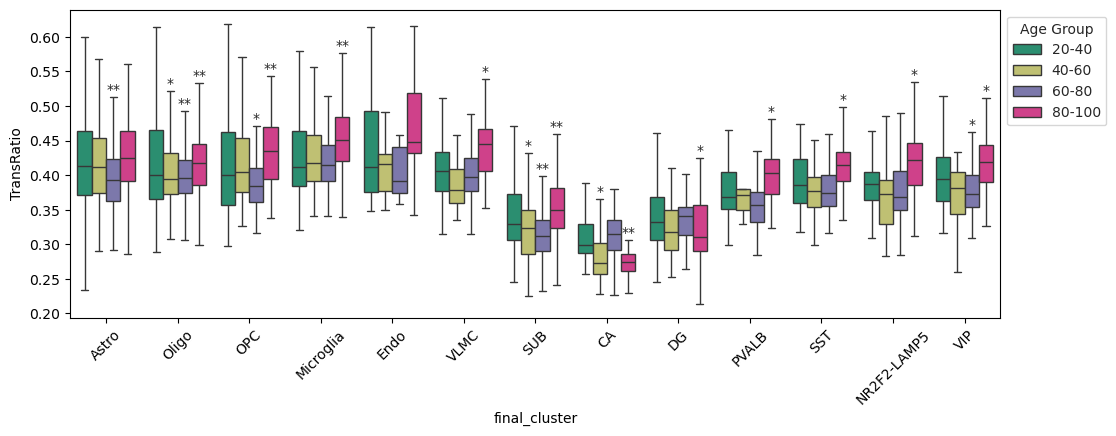

In [16]:
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(4)
sns.set_style("white")
sns.boxplot(
    meta_df, x="final_cluster", y="TransRatio", hue="group",
    ax=ax, palette=age_colors, showfliers=False
)
plt.legend(title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45);
x = [j + i for j in [-0.3, -0.1, 0.1, 0.3] for i in np.arange(0, 13)]
y = np.array([ax.get_lines()[i].get_ydata()[1] for i in np.arange(1, 260, 5)]) + 0.005
for k, (i, j) in enumerate(zip(x, y)):
    plt.text(i, j, test_results.iloc[k, 3], ha="center", fontsize=10)
fig.savefig(
    str(figure_dir / (f"All_age_trans_ratio" + ".pdf")),
    dpi=300,
    format="pdf",
    bbox_inches="tight"
)